In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch
if torch.cuda.is_available():
    device = torch.device("cuda") 
else:
    device = torch.device("cpu")

In [3]:
from src.dataloader import *
from src.models import *
from src.trainer import *
from src.utils import *
from src.layers import *

## Data

In [4]:
DATADRIVE = '/datadrive_ssd/'

In [5]:
ds_train = TiggeMRMSDataset(
    tigge_dir=f'{DATADRIVE}/tigge/32km/',
    tigge_vars=['total_precipitation'],
    mrms_dir=f'{DATADRIVE}/mrms/4km/RadarOnly_QPE_06H/',
    rq_fn=f'{DATADRIVE}/mrms/4km/RadarQuality.nc',
    data_period=('2018-01', '2018-12'),
    val_days=5,
    split='train',
#     tp_log=1e-1
)

/anaconda/envs/nwp-downscale/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


Loading data


In [6]:
ds_valid = TiggeMRMSDataset(
    tigge_dir=f'{DATADRIVE}/tigge/32km/',
    tigge_vars=['total_precipitation'],
    mrms_dir=f'{DATADRIVE}/mrms/4km/RadarOnly_QPE_06H/',
    rq_fn=f'{DATADRIVE}/mrms/4km/RadarQuality.nc',
    data_period=('2018-01', '2018-12'),
    val_days=5,
    split='valid',
#     tp_log=1e-1
)

/anaconda/envs/nwp-downscale/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


Loading data


In [7]:
sampler_train = torch.utils.data.WeightedRandomSampler(ds_train.compute_weights(), len(ds_train))
sampler_valid = torch.utils.data.WeightedRandomSampler(ds_valid.compute_weights(), len(ds_valid))

In [8]:
dl_train = torch.utils.data.DataLoader(ds_train, batch_size=16, sampler=sampler_train)
dl_valid = torch.utils.data.DataLoader(ds_valid, batch_size=16, sampler=sampler_valid)

In [9]:
len(ds_train), len(dl_train)

(20988, 1312)

## Leinonen-like architecture

In [10]:
gen = Generator(
    nres=3, nf_in=1, nf=256, use_noise=True, spectral_norm=True
).to(device)

In [11]:
disc = Discriminator(
    nf=256, ndown=4, nres=3, sigmoid=False, spectral_norm=True
).to(device)

In [12]:
count_parameters(gen)/1e6, count_parameters(disc)/1e6

(4.167607, 4.789025)

In [13]:
betas = (0.5, 0.9)
disc_optimizer = torch.optim.Adam(disc.parameters(), lr=1e-4, betas=betas)
gen_optimizer = torch.optim.Adam(gen.parameters(), lr=1e-4, betas=betas)

In [19]:
X_sample, y_sample = next(iter(dl_train))

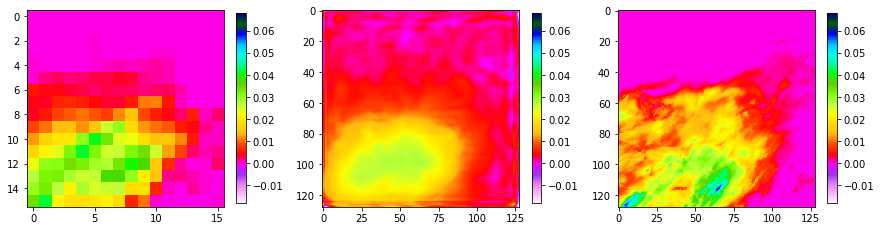

In [20]:
plot_sample(X_sample, y_sample, gen, 0)

## Pretraining

In [16]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(gen.parameters(), lr=1e-4)

In [17]:
trainer = Trainer(gen, optimizer, criterion, dl_train, dl_valid)

In [21]:
trainer.fit(1)

In [22]:
# torch.save(gen.state_dict(), f'gen_pretrained_sn.pt')
gen.load_state_dict(torch.load('gen_pretrained.pt'))

<All keys matched successfully>

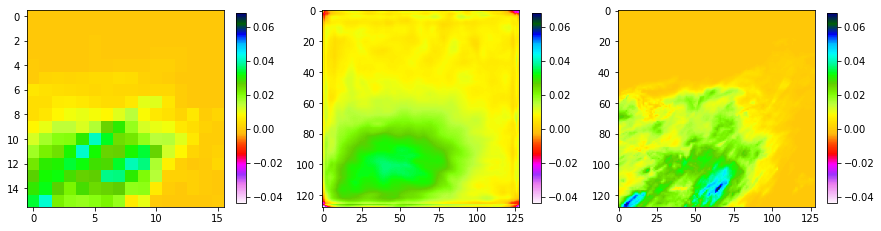

In [23]:
plot_sample(X_sample, y_sample, gen, 0)

## GAN

In [24]:
trainer = GANTrainer(
    gen, disc, gen_optimizer, disc_optimizer, dl_train, disc_repeats=5, l_loss='l1', 
    adv_loss_type='Wasserstein', gp_lambda=10,
    l_lambda=5, plot=True, plotting_sample=(X_sample, y_sample)
)

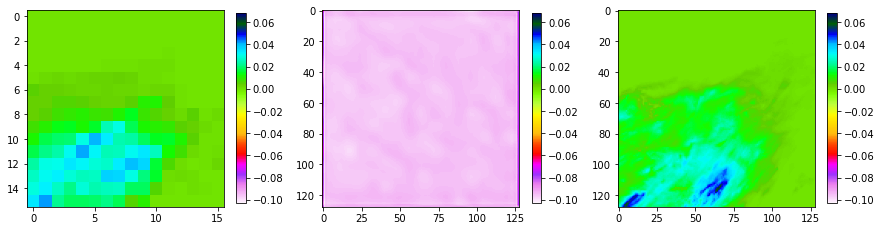

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



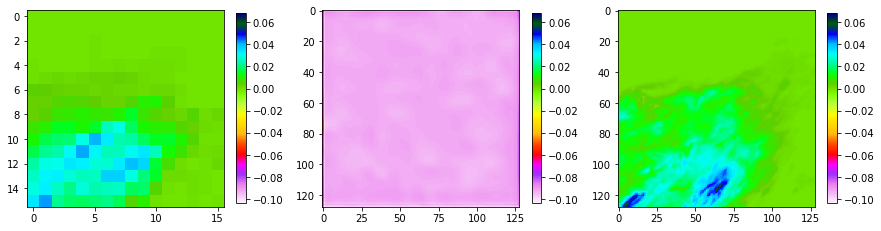

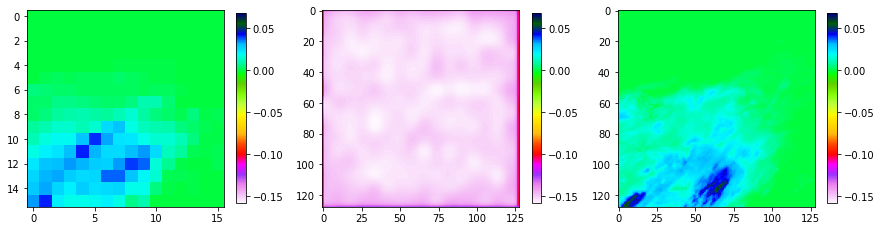

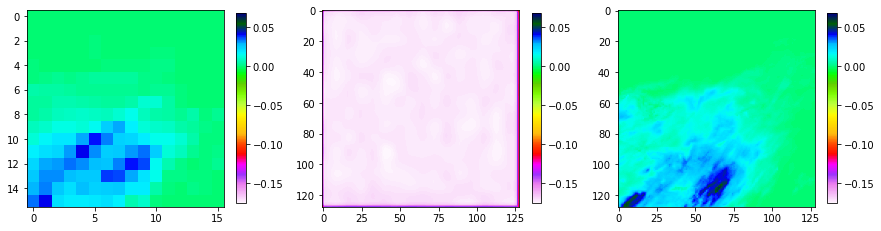

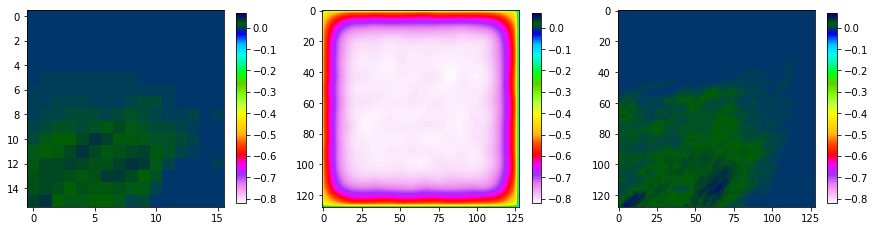

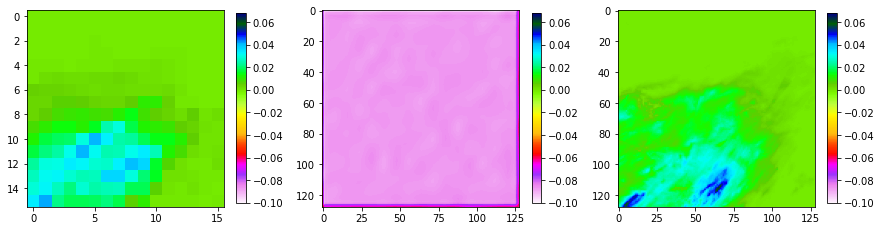

In [ ]:
trainer.fit(10)

Text(0.5, 1.0, 'Disc loss')

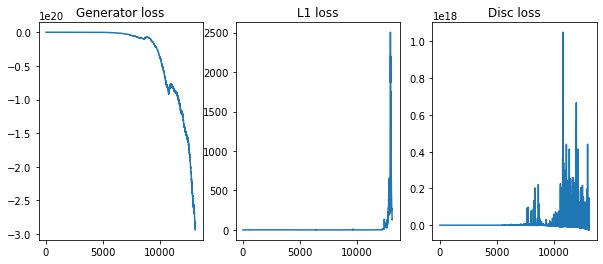

In [30]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 4))
ax1.plot(trainer.train_gen_losses); ax1.set_title('Generator loss')
ax2.plot(trainer.train_l_losses); ax2.set_title('L1 loss')
ax3.plot(trainer.train_disc_losses); ax3.set_title('Disc loss')

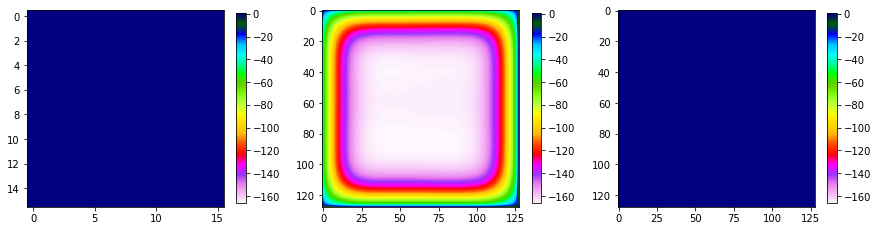

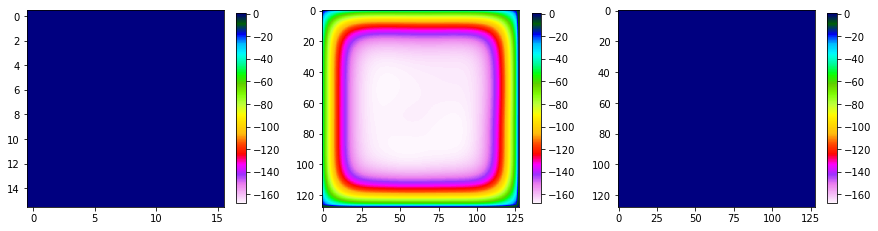

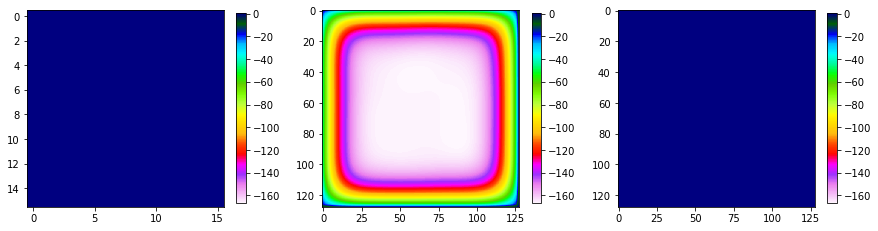

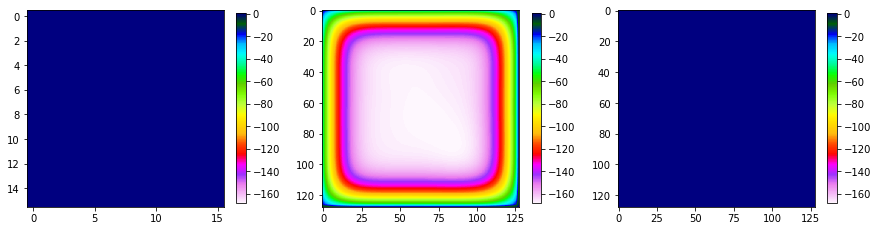

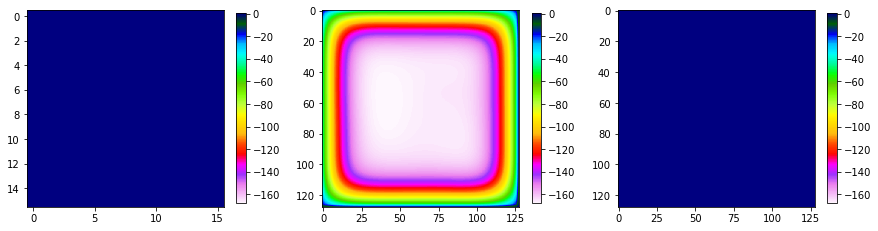

In [31]:
X, y = next(iter(dl_train))
for i in range(5):
    plot_sample(X, y, gen, i)

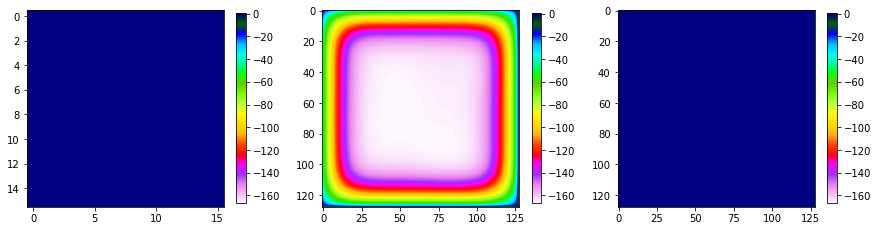

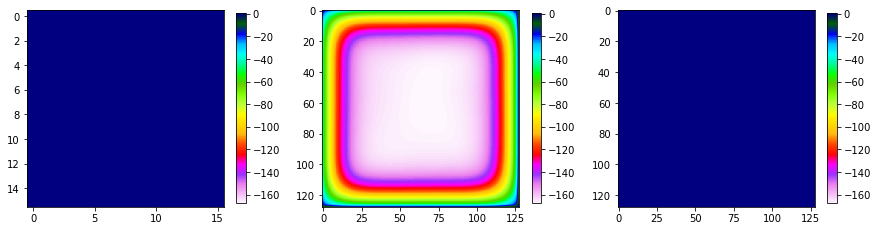

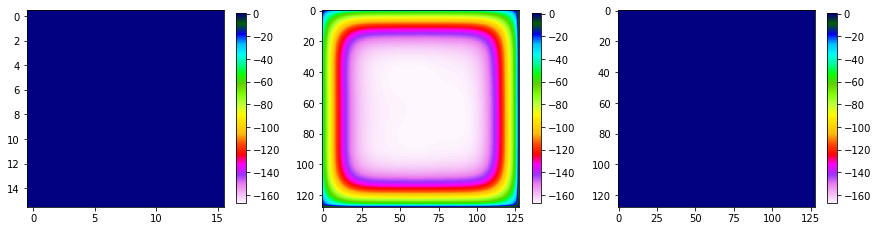

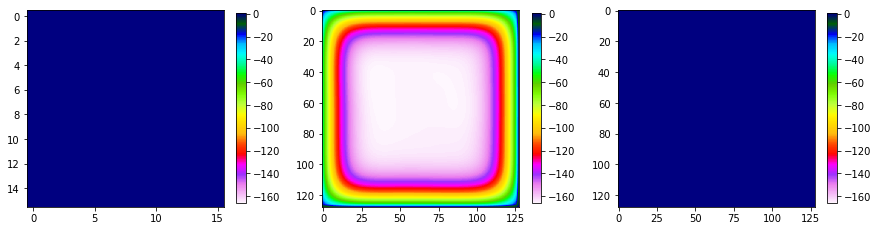

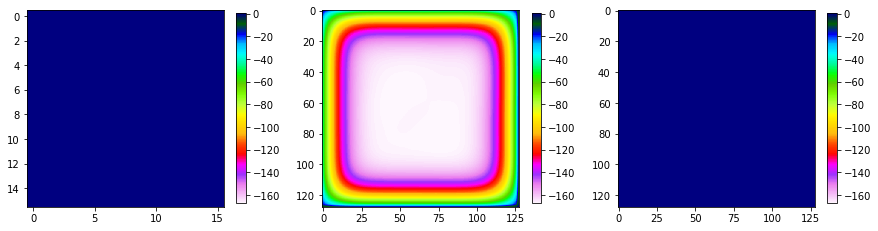

In [32]:
X, y = next(iter(dl_valid))
for i in range(5):
    plot_sample(X, y, gen, i)

(array([0., 6., 0., 0., 0., 0., 5., 0., 0., 1.]),
 array([2.9377603e+20, 2.9377603e+20, 2.9377603e+20, 2.9377605e+20,
        2.9377605e+20, 2.9377605e+20, 2.9377605e+20, 2.9377605e+20,
        2.9377607e+20, 2.9377607e+20, 2.9377607e+20], dtype=float32),
 <BarContainer object of 10 artists>)

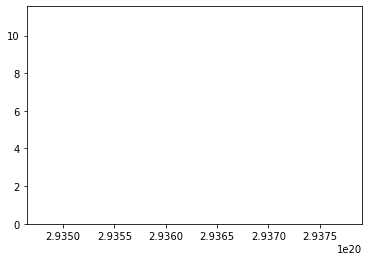

In [33]:
plt.hist(trainer.disc_preds_real[-1])
plt.hist(trainer.disc_preds_fake[-1])
plt.hist(trainer.gen_preds_fake[-1])